In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df=pd.read_csv('BrentOilPrices.csv')

In [3]:
#make dates the index
df.set_index(pd.DatetimeIndex(df.Date), inplace=True)
#fill date gaps
df = df.resample('D').pad()
#fix the Date column
df.Date = df.index.values
df.shape

C:\Users\DELL\AppData\Local\Temp\ipykernel_320\933005435.py:4: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  df = df.resample('D').pad()


(12963, 2)

In [4]:
df['Date']=pd.to_datetime(df['Date'])

In [5]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

In [6]:
df.set_index(df['Date'],inplace=True)

In [7]:
df1=df[(df['Date']>'2015-12-31') & (df['Date']<'2021-01-01')]

In [8]:
df1.shape

(1827, 2)

In [9]:
df1.drop('Date',axis=1,inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_320\2002264003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop('Date',axis=1,inplace=True)


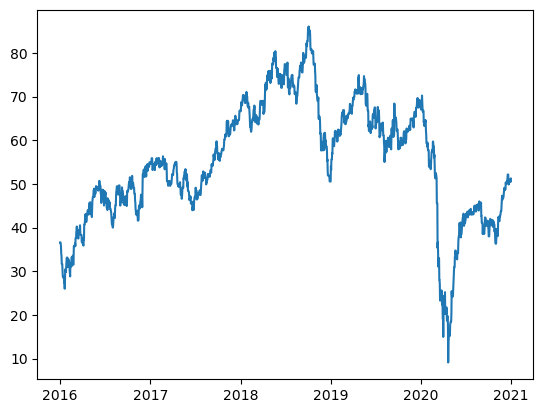

In [10]:
plt.plot(df1)

In [11]:
# additive
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 1200x800 with 0 Axes>

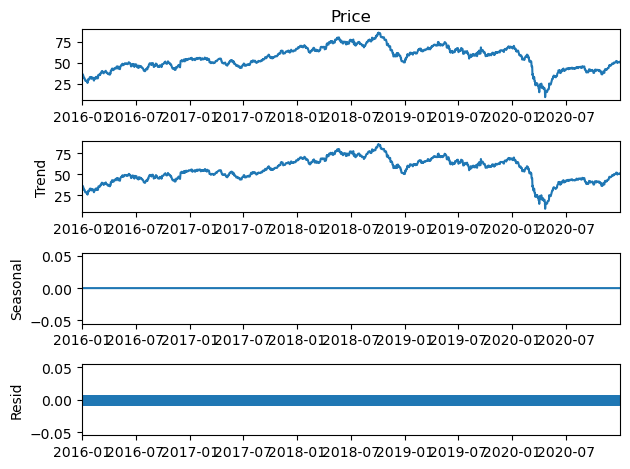

In [12]:
res_add = seasonal_decompose(df1['Price'], model='additive', period = 1 )
plt.figure(figsize = (12,8))
res_add.plot()
plt.show()

<Figure size 1200x800 with 0 Axes>

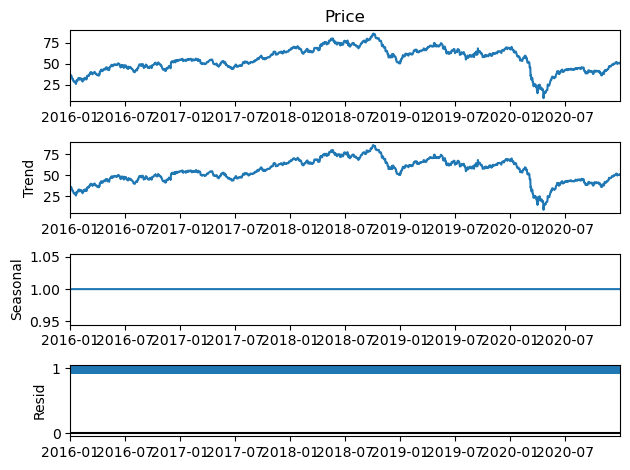

In [13]:
res_add = seasonal_decompose(df1['Price'], model='multiplicative', period = 1 )
plt.figure(figsize = (12,8))
res_add.plot()
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
def test_stationarity (timeseries) :
    # Perform Dickey Fuller Test
    
    print("\n Results of Dickey Fuller Test : ")
    dfttest = adfuller(timeseries, autolag='AIC')
    out = pd.Series(dfttest[:4], index = ['Test Statistics', 'P Value', 'Lags Used', 'No of Observation'])
    print(out)
                       

In [15]:
df1['log']=np.log(df1['Price'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_320\2737329206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log']=np.log(df1['Price'])


In [16]:
test_stationarity(df1['log'])


 Results of Dickey Fuller Test : 
Test Statistics        -3.147933
P Value                 0.023203
Lags Used              22.000000
No of Observation    1804.000000
dtype: float64


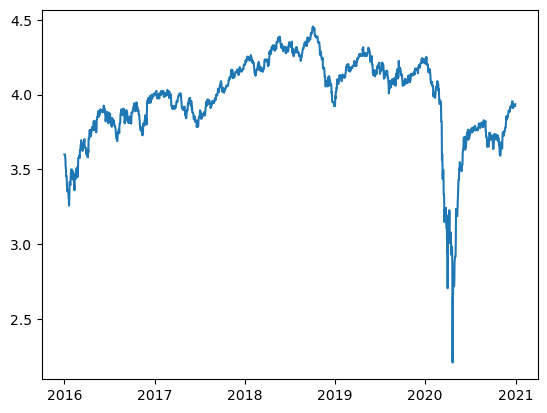

In [17]:
plt.plot(df1['log'])

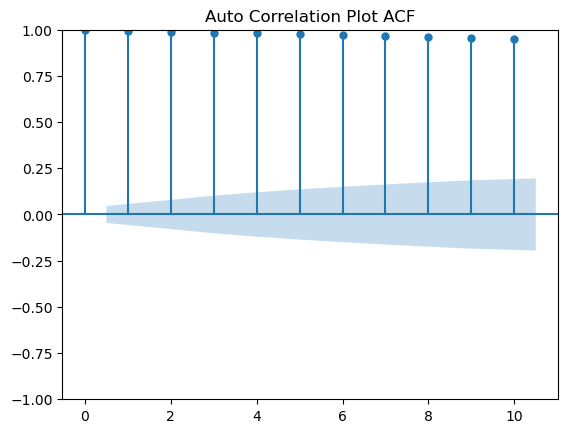

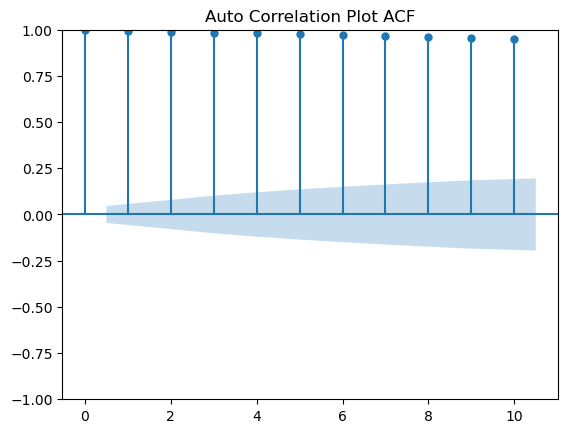

In [18]:
title = "Auto Correlation Plot ACF"
plot_acf(df1['log'].dropna(), lags= 10, title= title )

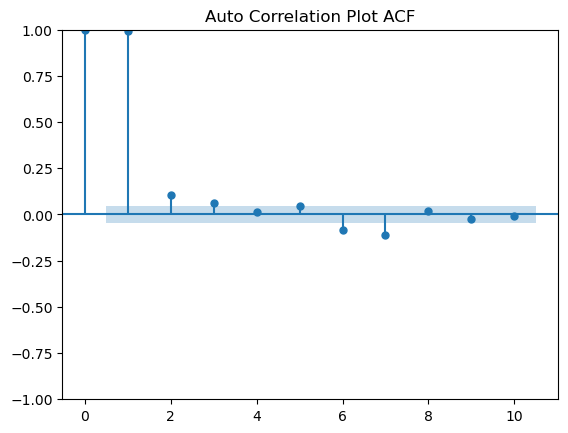

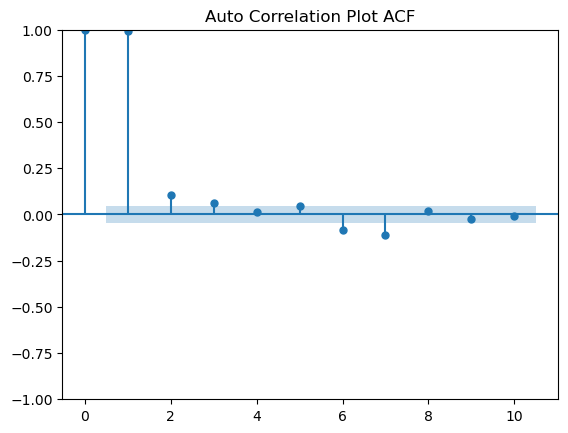

In [19]:
title = "Auto Correlation Plot ACF"
plot_pacf(df1['log'].dropna(), lags= 10, title= title,method='ywm')

In [20]:
model = ARIMA(df1['log'], order= (3,2,6))
result = model.fit()

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
predictions_ARIMA_diff  =  pd.Series(result.fittedvalues, copy = True)
predictions_ARIMA_diff

Date
2016-01-01    0.000000
2016-01-02    5.400482
2016-01-03    3.600321
2016-01-04    3.600321
2016-01-05    3.588796
                ...   
2020-12-27    3.928188
2020-12-28    3.932709
2020-12-29    3.932608
2020-12-30    3.921077
2020-12-31    3.928687
Length: 1827, dtype: float64

In [22]:
predictions_ARIMA =  np.exp(predictions_ARIMA_diff)

In [23]:
predictions_ARIMA.drop(index=['2016-01-01','2016-01-02'],axis=0,inplace=True)

In [24]:
test1 = df[df['Date']>'2020-12-31']

In [25]:
test=test1.drop(columns=['Date','Price'],axis=0)

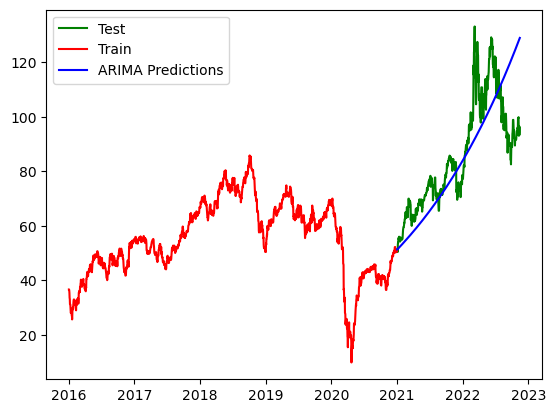

In [26]:
y_pred = result.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = result.predict(start = y_pred_df.index[0],end = y_pred_df.index[682])
y_pred_df.index[-1]
y_pred_df.index = test.index
y_pred_df["Predictions"]=np.exp(y_pred_df["Predictions"])
y_pred_out = y_pred_df["Predictions"] 

plt.plot(test1['Price'], color= 'green',label='Test')
plt.plot(predictions_ARIMA, color= 'red',label='Train')
plt.plot(y_pred_out, color='blue', label = 'ARIMA Predictions')
plt.legend()
plt.show()